## Question Answering Engine for Entity Span and Relation prediction

Download train, validation and test data from github repository.

In [3]:
!wget https://raw.githubusercontent.com/askplatypus/wikidata-simplequestions/master/annotated_wd_data_test_answerable.txt
!wget https://raw.githubusercontent.com/askplatypus/wikidata-simplequestions/master/annotated_wd_data_train_answerable.txt
!wget https://raw.githubusercontent.com/askplatypus/wikidata-simplequestions/master/annotated_wd_data_valid_answerable.txt

--2023-03-12 11:05:33--  https://raw.githubusercontent.com/askplatypus/wikidata-simplequestions/master/annotated_wd_data_test_answerable.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 345052 (337K) [text/plain]
Saving to: ‘annotated_wd_data_test_answerable.txt’

annotated_wd_data_t 100%[===================>] 336.96K  --.-KB/s    in 0.03s   

2023-03-12 11:05:33 (12.3 MB/s) - ‘annotated_wd_data_test_answerable.txt’ saved [345052/345052]

--2023-03-12 11:05:34--  https://raw.githubusercontent.com/askplatypus/wikidata-simplequestions/master/annotated_wd_data_train_answerable.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercon

Read train, validation and test data from txt to dataframes.

In [4]:
import warnings
warnings.simplefilter("ignore", UserWarning)
import pandas as pd

df_train = pd.read_csv("annotated_wd_data_train_answerable.txt", delimiter="\t", header=None, names=['entity_id', 'relation_id', 'answer_id', 'question'])
df_val = pd.read_csv("annotated_wd_data_valid_answerable.txt", delimiter="\t", header=None, names=['entity_id', 'relation_id', 'answer_id', 'question'])
df_test = pd.read_csv("annotated_wd_data_test_answerable.txt", delimiter="\t", header=None, names=['entity_id', 'relation_id', 'answer_id', 'question'])

# df_train = df_train.head(100)
# df_val = df_val.head(100)
# df_test = df_test.head(100)

df_train

,entity_id,relation_id,answer_id,question
0,Q12439,R19,Q6106580,who is a musician born in detroit
1,Q6817891,P364,Q1568,what is the language in which mera shikar was ...
2,Q1297,R276,Q2888523,Whats the name of a battle that happened in ch...
3,Q193592,R413,Q5822614,what player plays the position midfielder?
4,Q6849115,P413,Q336286,what is the position that mike twellman plays
...,...,...,...,...
19476,Q223960,P171,Q128001,what classification does mountain tapir come ...
19477,Q1535153,R136,Q7727315,What's a superhero movie that premiered on too...
19478,Q157443,R136,Q966690,What is the name of a comedy film that is also...
19479,Q16093542,P27,Q145,What is the nationality of anthony bailey


Preprocess data by lowercasing the questions and removing any punctuation. We should not preprocess further, as we may lose correlation between parts of each question and entities or relation.

The function data_preprocessing() can be used for any dataframe we want to preprocess/transform later.

In [5]:
def data_preprocessing(df):
    df['question'] = df['question'].str.lower() # lowercase
    df["question"] = df['question'].str.replace('[^\w\s]','', regex=True) # remove punctuation
    return df
    
df_train = data_preprocessing(df_train)
df_val = data_preprocessing(df_val)
df_test = data_preprocessing(df_test)

Insert every entity, relation and answer id into a single list and remove duplicates, so that we have the full vocabulary for which we need to find its matches through wikidata API.

In [6]:
train_entities = df_train['entity_id'].tolist()
train_relations = df_train['relation_id'].tolist()
train_answers = df_train['answer_id'].tolist()

val_entities = df_val['entity_id'].tolist()
val_relations = df_val['relation_id'].tolist()
val_answers = df_val['answer_id'].tolist()

test_entities = df_test['entity_id'].tolist()
test_relations = df_test['relation_id'].tolist()
test_answers = df_test['answer_id'].tolist()

all = train_entities + train_relations + train_answers + val_entities + val_relations + val_answers + test_entities + test_relations + test_answers
    
all = list(set(all))
print(len(all)) # unique ids

35122


Use SPARQLWrapper for python to get entity and relation names from wikidata, based on ids. We create a simple dictionary {"id": "name"} which will be used later for lookup.

In [7]:
import pickle
import time

id_to_label = {}

with open('id_to_label_final.pickle', 'rb') as handle:
    temp = pickle.load(handle)
    id_to_label.update(temp)

print(len(id_to_label))

################################################################################################
# Code that was used to obtain labels using SPARQL lookup and create the id_to_label dictionary:
################################################################################################

# !pip install SPARQLWrapper
# from SPARQLWrapper import SPARQLWrapper, JSON

# # Specify the DBPedia endpoint
# sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

# def wikidata_id_lookup(ids):
#     query =f'''
#            SELECT ?item ?itemLabel 
#            WHERE {{
#             VALUES ?item {{ {' '.join([f'wd:{i}' for i in ids])} }}
#             SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
#             }}
#         '''

#     sparql.setQuery(query)
#     sparql.setReturnFormat(JSON)
#     results = sparql.query().convert()
#     results_df = pd.json_normalize(results['results']['bindings'])

#     df = pd.DataFrame()
#     df['id'] = results_df['item.value'].map(lambda x : x.split('/')[-1])
#     df['label'] = results_df['itemLabel.value']
    
#     id_to_label = dict(zip(df.id, df.label))

#     return id_to_label

# # print(all[:3])
# # print(wikidata_id_lookup(all[:3]))
# id_to_label = {}
# # for i in range(0, int(len(all)/3), 100):
# count = 0
# print(int(len(all)/3))
# for i in range(2*int(len(all)/3), len(all), 100):
#     temp = wikidata_id_lookup(all[i:i+100])
#     id_to_label.update(temp)
#     count += 100
#     if count % 100 == 0:
#         print(i)
#         time.sleep(10)

# with open('/kaggle/input/wikidata-id-to-label/id_to_label1.pickle', 'rb') as handle:
#     temp = pickle.load(handle)
# #     print(len(temp))
#     id_to_label.update(temp)
    
# with open('/kaggle/input/wikidata-id-to-label/id_to_label2.pickle', 'rb') as handle:
#     temp = pickle.load(handle)
# #     print(len(temp))
#     id_to_label.update(temp)
    
# with open('/kaggle/input/wikidata-id-to-label/id_to_label3.pickle', 'rb') as handle:
#     temp = pickle.load(handle)
# #     print(len(temp))
#     id_to_label.update(temp)

# not_included = []
# for i in all:
#     if i not in id_to_label:
#         not_included.append(i)

# print(len(not_included))
# for i in range(0, len(not_included), 500):
#     temp = wikidata_id_lookup(not_included[i:i+500])
#     id_to_label.update(temp)
#     print(len(id_to_label))
#     time.sleep(20)

# with open('id_to_label_final.pickle', 'wb') as handle:
#     pickle.dump(id_to_label, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('id_to_label_final.pickle', 'rb') as handle:
#     id_to_label = pickle.load(handle)
    
# # print(id_to_label)
# print(len(id_to_label))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.3/500.3 kB 13.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.6 MB/s eta 0:00:00
35122


Create final dataframe of each dataset by adding entity and relation labels and converting questions into their span form, i.e. a list of 1s (for each word being an entity) and 0s (for each other word).

In [8]:
import re

def function_id_to_label(id):
    return id_to_label[id]

def question_entity_to_span(question, entity_label):
    entity_label = re.sub(r'[^\w\s]','',entity_label) # remove punctuation from label
    entity_label = entity_label.lower().split() # lowercase label
    question = question.split()
    return_list = []
    current = 0 # so that we can continue from where we left, if label has more than one words
    for e in entity_label:
        for i,q in enumerate(question[current:]):
            if e==q:
                return_list.append(1)
                current += 1
                break
            else:
                return_list.append(0)
            current += 1
    for i in range(current, len(question)):
        return_list.append(0)
    return return_list

def create_final_dataframe(df_init, id_to_label):
    final_dataframe = df_init
    
    # new columns by converting ids to labels
    final_dataframe['entity_label'] = final_dataframe.apply(lambda row: function_id_to_label(row.entity_id), axis=1)
    final_dataframe['relation_label'] = final_dataframe.apply(lambda row: function_id_to_label(row.relation_id), axis=1)
    
    # new column containg span
    final_dataframe['span'] = final_dataframe.apply(lambda row: question_entity_to_span(row.question, row.entity_label), axis=1)
    return final_dataframe

df_train = create_final_dataframe(df_train, id_to_label)
df_val = create_final_dataframe(df_val, id_to_label)
df_test = create_final_dataframe(df_test, id_to_label)

df_train
# print(df_train)

,entity_id,relation_id,answer_id,question,entity_label,relation_label,span
0,Q12439,R19,Q6106580,who is a musician born in detroit,Detroit,R19,"[0, 0, 0, 0, 0, 0, 1]"
1,Q6817891,P364,Q1568,what is the language in which mera shikar was ...,Mera Shikar,original language of film or TV show,"[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]"
2,Q1297,R276,Q2888523,whats the name of a battle that happened in ch...,Chicago,R276,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
3,Q193592,R413,Q5822614,what player plays the position midfielder,midfielder,R413,"[0, 0, 0, 0, 0, 1]"
4,Q6849115,P413,Q336286,what is the position that mike twellman plays,Mike Twellman,position played on team / speciality,"[0, 0, 0, 0, 0, 1, 1, 0]"
...,...,...,...,...,...,...,...
19476,Q223960,P171,Q128001,what classification does mountain tapir come ...,mountain tapir,parent taxon,"[0, 0, 0, 1, 1, 0, 0]"
19477,Q1535153,R136,Q7727315,whats a superhero movie that premiered on toonami,superhero film,R136,"[0, 0, 1, 0, 0, 0, 0, 0]"
19478,Q157443,R136,Q966690,what is the name of a comedy film that is also...,comedy film,R136,"[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]"
19479,Q16093542,P27,Q145,what is the nationality of anthony bailey,Anthony Bailey,country of citizenship,"[0, 0, 0, 0, 0, 1, 1]"


We only keep rows for which a valid span has been made (i.e. question entity has been correctly found). Some entities appear in different forms within the questions, than they appear in the entity vocabulary we got from the API (e.g. wrong apostrophes, misspelling etc.) so we ignore them (these are about 4% of each dataset, so we keep the remaining 96%).

We also calculate the max span length from all the spans of the training set, as well as the number of relation ids, that will be later used for the dimensions of our models' linear layers.

In [9]:
df_train = df_train.loc [ df_train['span'].map( lambda  x : True if 1 in x else False) ==  True ]
df_val = df_val.loc [ df_val['span'].map( lambda  x : True if 1 in x else False) ==  True ]
df_test = df_test.loc [ df_test['span'].map( lambda  x : True if 1 in x else False) ==  True ]

max_span_len = len(max(df_train.span, key=len))
relations_vocabulary = list(df_train['relation_id'].unique())
number_of_relation_ids = len(relations_vocabulary)
print(max_span_len, number_of_relation_ids)

33 125


Import bert tokenizer.

In [10]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

We transform the questions of our datasets according to the tokenizer bert provides.

In [11]:
train_encodings = tokenizer(df_train['question'].astype(str).values.tolist(), truncation=True, padding=True, return_attention_mask=True, max_length=256, return_tensors='pt')
val_encodings = tokenizer(df_val['question'].astype(str).values.tolist(), truncation=True, padding=True, return_attention_mask=True, max_length=256, return_tensors='pt')
test_encodings = tokenizer(df_test['question'].astype(str).values.tolist(), truncation=True, padding=True, return_attention_mask=True, max_length=256, return_tensors='pt')

Our y (target) datasets contain the span of each question and the relation id.

In [12]:
y1_train = df_train['span']
y1_val = df_val['span']
y1_test = df_test['span']

y2_train = df_train['relation_id']
y2_val = df_val['relation_id']
y2_test = df_test['relation_id']

We create a custom Dataset class which inherits the Dataset class of torch.utils.data and creates a dataset using the encodings created by the tokenizer and the target datasets created above.

In [13]:
import torch
from torch.utils.data import Dataset

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

class CustomDataset(Dataset):

  def __init__(self, x_dataset, y1_dataset, y2_dataset):

    self.encodings = x_dataset
    self.start_labels = [l.index(1) for l in y1_dataset] # index of first 1 in list
    self.end_labels = [len(l)-l[::-1].index(1)-1 for l in y1_dataset] # index of last 1 in list
    # index in relation vocabulary or vocabulary len (one step after vocabulary list's end) for
    # relation ids not found in vocabulary. This way, we create a new vocabulary entry for
    # ids not found in the initial vocabulary.
    self.relation_labels = [relations_vocabulary.index(i) if i in relations_vocabulary else number_of_relation_ids for i in y2_dataset]

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['start_labels'] = torch.tensor(self.start_labels[idx])
    item['end_labels'] = torch.tensor(self.end_labels[idx])
    item['relation_labels'] = torch.tensor(self.relation_labels[idx])
    return item

  def __len__(self):
    return len(self.start_labels)

Create train, validation and test datasets using the class we previously defined. Also print the size of each dataset.

In [14]:
train_dataset = CustomDataset(train_encodings, y1_train, y2_train)
validation_dataset = CustomDataset(val_encodings, y1_val, y2_val)
test_dataset = CustomDataset(test_encodings, y1_test, y2_test)

print("Train size is: ", train_dataset.__len__())
print("Validation size is: ", validation_dataset.__len__())
print("Test size is: ", test_dataset.__len__())

Train size is:  18754
Validation size is:  2727
Test size is:  5421


Batch size needs to be big enough so that we avoid noise, but small enough to allow the model to be trained fast, while using less memory. After experimenting with multiple batch sizes (8, 16, 32, 64) we define it as 32 here.

Although our models learn fast, we may need more than 10-15 epochs to achieve the best results.

In [15]:
batch_size = 32
num_epochs = 30

Create dataloaders for each set of data to use for the training, validation and evaluation of the models, later.

In [16]:
from torch.utils.data import Dataset

train_dataloader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size,
                                               shuffle = True)

validation_dataloader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size = batch_size,
                                                    shuffle = True)

test_dataloader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size,
                                              shuffle = True)

We define one model class for span prediction and one model class for relation prediction. Each model is initialized from the pretrained `bert-base-uncased` model. A dropout layer is also used, while each head uses a linear layer and a softmax before returning the results.

In [17]:
import torch.nn as nn
import transformers
from transformers import BertForSequenceClassification, AdamW

class BERTClassificationSpan(nn.Module):
    def __init__ (self):
        super(BERTClassificationSpan, self).__init__()
        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased')

        self.dropout = nn.Dropout(0.4)
        self.fc_start = nn.Linear(768, max_span_len)
        self.fc_end = nn.Linear(768, max_span_len)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, ids, mask, token_type_ids, labels=None):
        out, pooledOut = self.bert(ids, attention_mask = mask, token_type_ids=token_type_ids, return_dict=False)

        output = self.dropout(pooledOut)
        start_logits = self.fc_start(output)
        end_logits = self.fc_end(output)

        return self.softmax(start_logits), self.softmax(end_logits)
    
class BERTClassificationRelation(nn.Module):
    def __init__ (self):
        super(BERTClassificationRelation, self).__init__()
        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased')

        self.dropout = nn.Dropout(0.4)
        self.fc_relation = nn.Linear(768, number_of_relation_ids+1) # +1 because we also have a special
                                                                    # index for relations not found in
                                                                    # the vocabulary
        self.softmax = nn.Softmax(dim=1)

    def forward(self, ids, mask, token_type_ids, labels=None):
        out, pooledOut = self.bert(ids, attention_mask = mask, token_type_ids=token_type_ids, return_dict=False)

        output = self.dropout(pooledOut)
        relation_logits = self.fc_relation(output)

        return self.softmax(relation_logits)

We also define a function that will help us plot the results

In [18]:
def create_plots(title, train_loss, val_loss, train_accuracy, val_accuracy, train_precision, val_precision, train_recall, val_recall,
                train_f1, val_f1):
    fig, axs = plt.subplots(2, 3, figsize=(15, 7))
    fig.patch.set_facecolor('white')
    fig.suptitle(title, fontsize=15)

    axs[0, 0].plot(range(num_epochs), train_loss, label="train set")
    axs[0, 0].plot(range(num_epochs), val_loss, label="validation set")
    axs[0, 0].set_title('Cross Entropy Loss')
    axs[0, 0].set_ylim([0, 4])

    axs[0, 1].plot(range(num_epochs), train_accuracy, label="train set")
    axs[0, 1].plot(range(num_epochs), val_accuracy, label="validation set")
    axs[0, 1].set_title('Accuracy')
    axs[0, 1].set_ylim([0, 1])

    axs[0, 2].plot(range(num_epochs), train_precision, label="train set")
    axs[0, 2].plot(range(num_epochs), val_precision, label="validation set")
    axs[0, 2].set_title('Precision')
    axs[0, 2].set_ylim([0, 1])

    axs[1, 0].plot(range(num_epochs), train_recall, label="train set")
    axs[1, 0].plot(range(num_epochs), val_recall, label="validation set")
    axs[1, 0].set_title('Recall')
    axs[1, 0].set_ylim([0, 1])

    axs[1, 1].plot(range(num_epochs), train_f1, label="train set")
    axs[1, 1].plot(range(num_epochs), val_f1, label="validation set")
    axs[1, 1].set_title('F1')
    axs[1, 1].set_ylim([0, 1])
    
    fig.delaxes(axs[1, 2])

    axs[0][0].legend()
    axs[0][1].legend()
    axs[0][2].legend()
    axs[1][0].legend()
    axs[1][1].legend()

The following function helps us train our previously defined model for span prediction, export statistics about its scores on both train and validation sets and plot them.

In [19]:
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

def train_model_span(model, num_epochs, train_dataloader, validation_dataloader, criterion, optimizer, plots = False):
  
  train_loss, val_loss = [], []

  train_accuracy_start_labels, val_accuracy_start_labels, train_precision_start_labels,\
  val_precision_start_labels, train_recall_start_labels, val_recall_start_labels,\
  train_f1_start_labels, val_f1_start_labels = ([] for i in range(8))

  train_accuracy_end_labels, val_accuracy_end_labels, train_precision_end_labels,\
  val_precision_end_labels, train_recall_end_labels, val_recall_end_labels,\
  train_f1_end_labels, val_f1_end_labels = ([] for i in range(8))

  for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      start_labels = batch['start_labels'].to(device)
      end_labels = batch['end_labels'].to(device)
      token_type_ids = batch["token_type_ids"].to(device)
    
      start_outputs, end_outputs = model(input_ids, attention_mask, token_type_ids)
          
      start_loss = criterion(start_outputs, start_labels)
      end_loss = criterion(end_outputs, end_labels)
      loss = (start_loss + end_loss) / 2

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    # no gradients needed
    model.eval()
    with torch.no_grad():

      # checking fit for the training set itself

      all_train_start_labels = np.array([])
      all_train_start_predictions = np.array([])
    
      all_train_end_labels = np.array([])
      all_train_end_predictions = np.array([])
    
      losses = np.array([])
      for batch in train_dataloader:
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_labels = batch['start_labels'].to(device)
        end_labels = batch['end_labels'].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        
        start_outputs, end_outputs = model(input_ids, attention_mask, token_type_ids)
        
        _, start_predictions = torch.max(start_outputs, 1)
        _, end_predictions = torch.max(end_outputs, 1)

        start_loss = criterion(start_outputs, start_labels)
        end_loss = criterion(end_outputs, end_labels)
        loss = (start_loss + end_loss) / 2
        losses = np.append(losses, loss.item())
        
        all_train_start_labels = np.append(all_train_start_labels, start_labels.cpu().numpy())
        all_train_start_predictions = np.append(all_train_start_predictions, start_predictions.cpu().numpy())
        
        all_train_end_labels = np.append(all_train_end_labels, end_labels.cpu().numpy())
        all_train_end_predictions = np.append(all_train_end_predictions, end_predictions.cpu().numpy())   

      train_loss.append(np.mean(losses))
    
      train_accuracy_start_labels.append(accuracy_score(all_train_start_labels, all_train_start_predictions))
      train_precision_start_labels.append(precision_score(all_train_start_labels, all_train_start_predictions, average='weighted'))
      train_recall_start_labels.append(recall_score(all_train_start_labels, all_train_start_predictions, average='weighted'))
      train_f1_start_labels.append(f1_score(all_train_start_labels, all_train_start_predictions, average='weighted'))
    
      train_accuracy_end_labels.append(accuracy_score(all_train_end_labels, all_train_end_predictions))
      train_precision_end_labels.append(precision_score(all_train_end_labels, all_train_end_predictions, average='weighted'))
      train_recall_end_labels.append(recall_score(all_train_end_labels, all_train_end_predictions, average='weighted'))
      train_f1_end_labels.append(f1_score(all_train_end_labels, all_train_end_predictions, average='weighted'))

      # checking fit for validation set

      all_val_start_labels = np.array([])
      all_val_start_predictions = np.array([])
      all_val_start_outputs = np.array([])
    
      all_val_end_labels = np.array([])
      all_val_end_predictions = np.array([])
      all_val_end_outputs = np.array([])
    
      losses = np.array([])

      for batch in validation_dataloader:
            
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_labels = batch['start_labels'].to(device)
        end_labels = batch['end_labels'].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        
        start_outputs, end_outputs = model(input_ids, attention_mask, token_type_ids)
        
        _, start_predictions = torch.max(start_outputs, 1)
        _, end_predictions = torch.max(end_outputs, 1)
        
        start_loss = criterion(start_outputs, start_labels)
        end_loss = criterion(end_outputs, end_labels)
        loss = (start_loss + end_loss) / 2
        losses = np.append(losses, loss.item())
            
        all_val_start_labels = np.append(all_val_start_labels, start_labels.cpu().numpy())
        all_val_start_predictions = np.append(all_val_start_predictions, start_predictions.cpu().numpy())
        
        all_val_end_labels = np.append(all_val_end_labels, end_labels.cpu().numpy())
        all_val_end_predictions = np.append(all_val_end_predictions, end_predictions.cpu().numpy())  

      val_loss.append(np.mean(losses))
    
      val_accuracy_start_labels.append(accuracy_score(all_val_start_labels, all_val_start_predictions))
      val_precision_start_labels.append(precision_score(all_val_start_labels, all_val_start_predictions, average='weighted'))
      val_recall_start_labels.append(recall_score(all_val_start_labels, all_val_start_predictions, average='weighted'))
      val_f1_start_labels.append(f1_score(all_val_start_labels, all_val_start_predictions, average='weighted'))
    
      val_accuracy_end_labels.append(accuracy_score(all_val_end_labels, all_val_end_predictions))
      val_precision_end_labels.append(precision_score(all_val_end_labels, all_val_end_predictions, average='weighted'))
      val_recall_end_labels.append(recall_score(all_val_end_labels, all_val_end_predictions, average='weighted'))
      val_f1_end_labels.append(f1_score(all_val_end_labels, all_val_end_predictions, average='weighted'))

  # plots / learning curves
  # plots may be False if we are just tuning our model and don't need these curves
  if plots:
    create_plots("Start Index", train_loss, val_loss, train_accuracy_start_labels, val_accuracy_start_labels, 
                 train_precision_start_labels, val_precision_start_labels, train_recall_start_labels,
                 val_recall_start_labels, train_f1_start_labels, val_f1_start_labels)
    
    create_plots("End Index", train_loss, val_loss, train_accuracy_end_labels, val_accuracy_end_labels,
                 train_precision_end_labels, val_precision_end_labels, train_recall_end_labels,
                 val_recall_end_labels, train_f1_end_labels, val_f1_end_labels)

  return all_train_start_labels, all_train_start_predictions, all_val_start_labels, all_val_start_predictions,\
         all_train_end_labels, all_train_end_predictions, all_val_end_labels, all_val_end_predictions

The following function helps us train our previously defined model for relation prediction, export statistics about its scores on both train and validation sets and plot them.

In [20]:
def train_model_relation(model, num_epochs, train_dataloader, validation_dataloader, criterion, optimizer, plots = False):
  
  train_loss, val_loss = [], []
    
  train_accuracy_relation_labels, val_accuracy_relation_labels, train_precision_relation_labels,\
  val_precision_relation_labels, train_recall_relation_labels, val_recall_relation_labels,\
  train_f1_relation_labels, val_f1_relation_labels = ([] for i in range(8))

  for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      relation_labels = batch['relation_labels'].to(device)
      token_type_ids = batch["token_type_ids"].to(device)
    
      relation_outputs = model(input_ids, attention_mask, token_type_ids)

      loss = criterion(relation_outputs, relation_labels)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    # no gradients needed
    model.eval()
    with torch.no_grad():

      # checking fit for the training set itself
    
      all_train_relation_labels = np.array([])
      all_train_relation_predictions = np.array([])
    
      losses = np.array([])
      for batch in train_dataloader:
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        relation_labels = batch['relation_labels'].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        
        relation_outputs = model(input_ids, attention_mask, token_type_ids)

        _, relation_predictions = torch.max(relation_outputs, 1)

        loss = criterion(relation_outputs, relation_labels)
        losses = np.append(losses, loss.item())
        
        all_train_relation_labels = np.append(all_train_relation_labels, relation_labels.cpu().numpy())
        all_train_relation_predictions = np.append(all_train_relation_predictions, relation_predictions.cpu().numpy())

      train_loss.append(np.mean(losses))
    
      train_accuracy_relation_labels.append(accuracy_score(all_train_relation_labels, all_train_relation_predictions))
      train_precision_relation_labels.append(precision_score(all_train_relation_labels, all_train_relation_predictions, average='weighted'))
      train_recall_relation_labels.append(recall_score(all_train_relation_labels, all_train_relation_predictions, average='weighted'))
      train_f1_relation_labels.append(f1_score(all_train_relation_labels, all_train_relation_predictions, average='weighted'))

      # checking fit for validation set

      all_val_relation_labels = np.array([])
      all_val_relation_predictions = np.array([])
      all_val_relation_outputs = np.array([])
    
      losses = np.array([])

      for batch in validation_dataloader:
            
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        relation_labels = batch['relation_labels'].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        
        relation_outputs = model(input_ids, attention_mask, token_type_ids)
        
        _, relation_predictions = torch.max(relation_outputs, 1)
        
        loss = criterion(relation_outputs, relation_labels)
        losses = np.append(losses, loss.item())
        
        all_val_relation_labels = np.append(all_val_relation_labels, relation_labels.cpu().numpy())
        all_val_relation_predictions = np.append(all_val_relation_predictions, relation_predictions.cpu().numpy())

      val_loss.append(np.mean(losses))
    
      val_accuracy_relation_labels.append(accuracy_score(all_val_relation_labels, all_val_relation_predictions))
      val_precision_relation_labels.append(precision_score(all_val_relation_labels, all_val_relation_predictions, average='weighted'))
      val_recall_relation_labels.append(recall_score(all_val_relation_labels, all_val_relation_predictions, average='weighted'))
      val_f1_relation_labels.append(f1_score(all_val_relation_labels, all_val_relation_predictions, average='weighted'))

  # plots / learning curves
  # plots may be False if we are just tuning our model and don't need these curves
  if plots:
    create_plots("Relation Index", train_loss, val_loss, train_accuracy_relation_labels, val_accuracy_relation_labels,
                 train_precision_relation_labels, val_precision_relation_labels,
                 train_recall_relation_labels, val_recall_relation_labels, train_f1_relation_labels,
                 val_f1_relation_labels)

  return all_train_relation_labels, all_train_relation_predictions, all_val_relation_labels, all_val_relation_predictions

Fine tune Bert model for span prediction and get a classification report for both training and validation sets. Then, by examining whether the scores for these sets are close to each other or not, we can determine if the model overfits or underfits. This can also be seen in the plots following these statistics, where the training and validation curves remain very close to each other with a very small generalization gap, showing that no overfitting or underfitting occurs in our model.

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Start Index


Train set:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       252
         1.0       0.00      0.00      0.00       476
         2.0       0.87      1.00      0.93      4497
         3.0       0.99      0.99      0.99      4308
         4.0       0.98      0.97      0.98      2152
         5.0       0.98      0.99      0.98      3853
         6.0       0.96      0.96      0.96      1536
         7.0       0.95      0.97      0.96       981
         8.0       0.73      0.95      0.82       392
         9.0       0.45      0.46      0.46       188
        10.0       0.00      0.00      0.00        66
        11.0       0.00      0.00      0.00        36
        12.0       0.00      0.00      0.00        11
        13.0       0.00      0.00      0.00         3
        14.0       0.00      0.00      0.00         2
        15.0       0.00      0.00      0.00         1

    accuracy                           0.93     1875

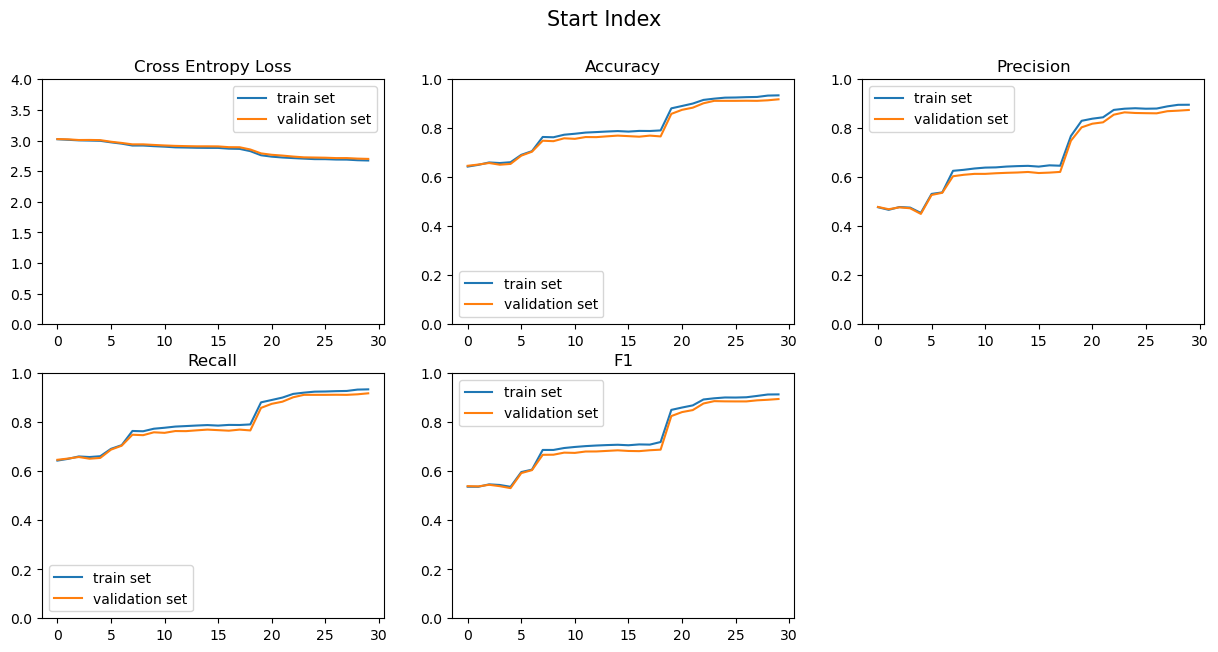

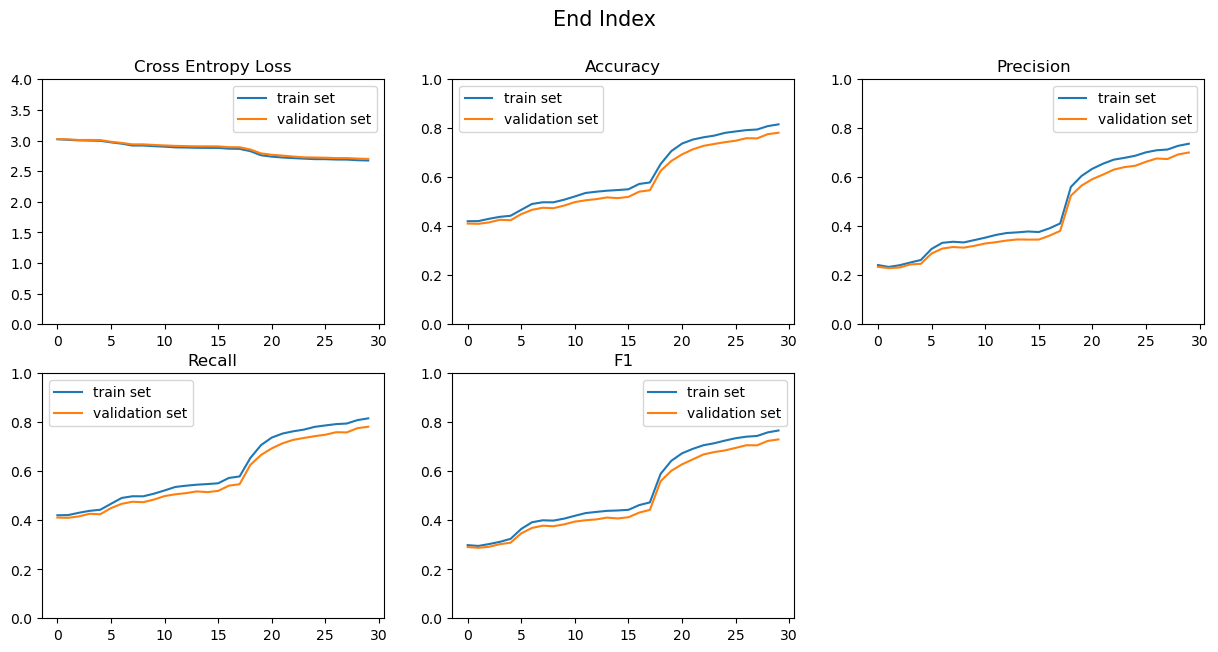

In [19]:
from sklearn.metrics import classification_report
from torch import nn

model_span = BERTClassificationSpan().to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(model_span.parameters(), lr = 0.00001)

y_train_start, train_outputs_start, y_val_start, val_outputs_start,\
y_train_end, train_outputs_end, y_val_end, val_outputs_end,\
= train_model_span(model_span, num_epochs, train_dataloader, validation_dataloader,
                                                         criterion, optimizer, plots = True)

print("\n\nStart Index\n\n")
print("Train set:\n", classification_report(y_train_start, train_outputs_start))
print("Validation set:\n", classification_report(y_val_start, val_outputs_start))
print("\n\nEnd Index\n\n")
print("Train set:\n", classification_report(y_train_end, train_outputs_end))
print("Validation set:\n", classification_report(y_val_end, val_outputs_end))

Also save this trained model for later use.

In [ ]:
torch.save(model_span.state_dict(), "model_span")
model_span = BERTClassificationSpan().to(device)
model_span.load_state_dict(torch.load("model_span"))

Evaluation of our model using the test set created in the beginning of this notebook. This test set has not been used anywhere so far, so it contains representative random samples that the model has never seen before.

In [23]:
from sklearn.metrics import accuracy_score

all_test_start_labels = np.array([])
all_test_start_predictions = np.array([])

all_test_end_labels = np.array([])
all_test_end_predictions = np.array([])

model_span.eval()

with torch.no_grad():
  for batch in test_dataloader:
    
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_labels = batch['start_labels'].to(device)
    end_labels = batch['end_labels'].to(device)
    token_type_ids = batch["token_type_ids"].to(device)

    start_outputs, end_outputs = model_span(input_ids, attention_mask, token_type_ids)

    _, start_predictions = torch.max(start_outputs, 1)
    _, end_predictions = torch.max(end_outputs, 1)
    
    all_test_start_labels = np.append(all_test_start_labels, start_labels.cpu().numpy())
    all_test_end_labels = np.append(all_test_end_labels, end_labels.cpu().numpy())

    all_test_start_predictions = np.append(all_test_start_predictions, start_predictions.cpu().numpy())
    all_test_end_predictions = np.append(all_test_end_predictions, end_predictions.cpu().numpy())

print("Test set - Start labels:\n", classification_report(all_test_start_labels, all_test_start_predictions))
print("Accuracy: ", accuracy_score(all_test_start_labels, all_test_start_predictions))
print("\n\nTest set - End labels:\n", classification_report(all_test_end_labels, all_test_end_predictions))
print("Accuracy: ", accuracy_score(all_test_end_labels, all_test_end_predictions))

Test set - Start labels:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        79
         1.0       0.00      0.00      0.00       136
         2.0       0.85      0.98      0.91      1289
         3.0       0.97      0.98      0.98      1255
         4.0       0.96      0.97      0.96       602
         5.0       0.97      0.98      0.98      1114
         6.0       0.96      0.92      0.94       440
         7.0       0.91      0.94      0.93       292
         8.0       0.61      0.93      0.74        96
         9.0       0.49      0.44      0.46        77
        10.0       0.00      0.00      0.00        22
        11.0       0.00      0.00      0.00        11
        12.0       0.00      0.00      0.00         7
        13.0       0.00      0.00      0.00         1

    accuracy                           0.92      5421
   macro avg       0.48      0.51      0.49      5421
weighted avg       0.88      0.92      0.90      5421


Fine tune Bert model for relation prediction and get a classification report for both training and validation sets. Then, by examining whether the scores for these sets are close to each other or not, we can determine if the model overfits or underfits. This can also be seen in the plots following these statistics, where the training and validation curves remain very close to each other with a very small generalization gap, showing that no overfitting or underfitting occurs in our model.

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Relation Index


Train set:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       903
         1.0       0.96      1.00      0.98       678
         2.0       0.92      1.00      0.96        45
         3.0       0.99      0.99      0.99       348
         4.0       0.99      1.00      1.00       836
         5.0       0.98      1.00      0.99       735
         6.0       0.97      0.98      0.98      1500
         7.0       1.00      1.00      1.00      1446
         8.0       0.98      0.96      0.97       228
         9.0       0.00      0.00      0.00        97
        10.0       0.92      1.00      0.96       464
        11.0       0.97      0.99      0.98       287
        12.0       0.89      0.99      0.94       108
        13.0       0.76      0.96      0.85        53
        14.0       0.97      1.00      0.98      1502
        15.0       0.00      0.00      0.00        27
        16.0       0.96      0.98      0.97      1

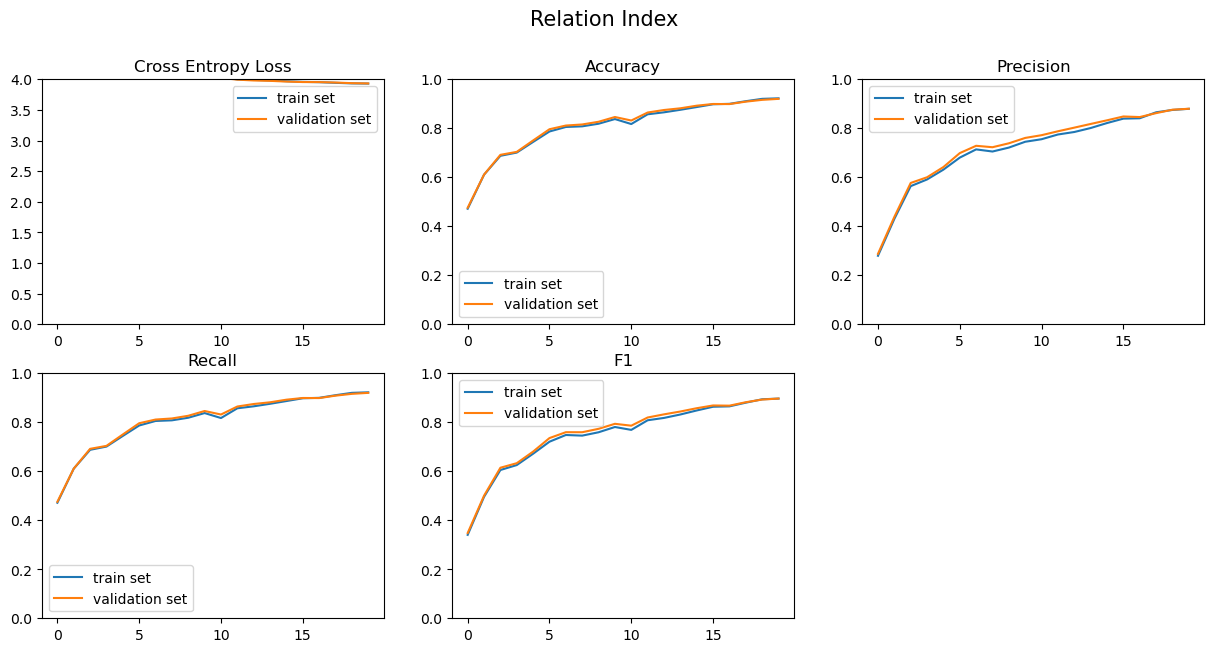

In [22]:
model_relation = BERTClassificationRelation().to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(model_relation.parameters(), lr = 0.00001)

num_epochs = 20

y_train_relation, train_outputs_relation, y_val_relation, val_outputs_relation\
= train_model_relation(model_relation, num_epochs, train_dataloader, validation_dataloader,
                                                         criterion, optimizer, plots = True)

print("\n\nRelation Index\n\n")
print("Train set:\n", classification_report(y_train_relation, train_outputs_relation))
print("Validation set:\n", classification_report(y_val_relation, val_outputs_relation))

Also save this trained model for later use.

In [ ]:
torch.save(model_relation.state_dict(), "model_relation")
model_relation = BERTClassificationRelation().to(device)
model_relation.load_state_dict(torch.load("model_relation"))

Evaluation of our model using the test set created in the beginning of this notebook. This test set has not been used anywhere so far, so it contains representative random samples that the model has never seen before.

In [25]:
all_test_relation_labels = np.array([])
all_test_relation_predictions = np.array([])

model_span.eval()

with torch.no_grad():
  for batch in test_dataloader:
    
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    relation_labels = batch['relation_labels'].to(device)
    token_type_ids = batch["token_type_ids"].to(device)

    relation_outputs = model_relation(input_ids, attention_mask, token_type_ids)

    _, relation_predictions = torch.max(relation_outputs, 1)
    
    all_test_relation_labels = np.append(all_test_relation_labels, relation_labels.cpu().numpy())

    all_test_relation_predictions = np.append(all_test_relation_predictions, relation_predictions.cpu().numpy())

print("Test set - Relation labels:\n", classification_report(all_test_relation_labels, all_test_relation_predictions))
print("Accuracy: ", accuracy_score(all_test_relation_labels, all_test_relation_predictions))

Test set - Relation labels:
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       270
         1.0       0.95      1.00      0.98       212
         2.0       0.79      1.00      0.88        11
         3.0       0.94      1.00      0.97        80
         4.0       1.00      0.99      1.00       231
         5.0       0.96      0.96      0.96       215
         6.0       0.94      0.95      0.95       425
         7.0       1.00      0.99      1.00       438
         8.0       0.95      0.89      0.92        80
         9.0       0.00      0.00      0.00        25
        10.0       0.85      0.97      0.91       145
        11.0       0.96      0.92      0.94        72
        12.0       0.71      0.92      0.80        24
        13.0       0.63      1.00      0.77        12
        14.0       0.95      0.98      0.97       443
        15.0       0.00      0.00      0.00         4
        16.0       0.94      0.97      0.96       45

Section for testing with a new test dataset given by the user. Just insert the path of your test csv file in the `path_to_your_test_set` variable and run the code (while having already run the code written before this message).
After running the following code, a classification report providing precision, recall and F-measure for your test set will be printed on the screen.

In [ ]:
#########################################
############# YOUR TEST SET #############
#########################################

path_to_your_test_set = ""

my_df_test = pd.read_csv(path_to_your_test_set, delimiter="\t", header=None, names=['entity_id', 'relation_id', 'answer_id', 'question'])

my_df_test = data_preprocessing(my_df_test)

my_df_test = create_final_dataframe(my_df_test, id_to_label)

my_df_test = my_df_test.loc [ my_df_test['span'].map( lambda  x : True if 1 in x else False) ==  True ]

test_encodings = tokenizer(my_df_test['question'].astype(str).values.tolist(), truncation=True, padding=True, return_attention_mask=True, max_length=256, return_tensors='pt')

my_y1_test = my_df_test['span']

my_y2_test = my_df_test['relation_id']

my_test_dataset = CustomDataset(test_encodings, y1_test, y2_test)

my_test_dataloader = torch.utils.data.DataLoader(dataset = my_test_dataset, batch_size = batch_size,
                                              shuffle = True)

all_test_start_labels = np.array([])
all_test_start_predictions = np.array([])

all_test_end_labels = np.array([])
all_test_end_predictions = np.array([])

all_test_relation_labels = np.array([])
all_test_relation_predictions = np.array([])

model_span.eval()

with torch.no_grad():
  for batch in my_test_dataloader:
    
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_labels = batch['start_labels'].to(device)
    end_labels = batch['end_labels'].to(device)
    relation_labels = batch['relation_labels'].to(device)
    token_type_ids = batch["token_type_ids"].to(device)

    start_outputs, end_outputs = model_span(input_ids, attention_mask, token_type_ids)
    relation_outputs = model_relation(input_ids, attention_mask, token_type_ids)

    _, start_predictions = torch.max(start_outputs, 1)
    _, end_predictions = torch.max(end_outputs, 1)
    _, relation_predictions = torch.max(relation_outputs, 1)
    
    all_test_start_labels = np.append(all_test_start_labels, start_labels.cpu().numpy())
    all_test_end_labels = np.append(all_test_end_labels, end_labels.cpu().numpy())
    all_test_relation_labels = np.append(all_test_relation_labels, relation_labels.cpu().numpy())

    all_test_start_predictions = np.append(all_test_start_predictions, start_predictions.cpu().numpy())
    all_test_end_predictions = np.append(all_test_end_predictions, end_predictions.cpu().numpy())
    all_test_relation_predictions = np.append(all_test_relation_predictions, relation_predictions.cpu().numpy())

print("My Test set - Start labels:\n", classification_report(all_test_start_labels, all_test_start_predictions))
print("Accuracy: ", accuracy_score(all_test_start_labels, all_test_start_predictions))
print("\n\nMy Test set - End labels:\n", classification_report(all_test_end_labels, all_test_end_predictions))
print("Accuracy: ", accuracy_score(all_test_end_labels, all_test_end_predictions))
print("\n\nMy Test set - Relation labels:\n", classification_report(all_test_relation_labels, all_test_relation_predictions))
print("Accuracy: ", accuracy_score(all_test_relation_labels, all_test_relation_predictions))